# Bayes Theorem for Predicting the Probability of an Email Being Spam

S = Spam
w = Word

$P(Spam|w_{1}, w_{2},..., w_{n}) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_{i}|Spam)$

The probability that an email consisting of the words $w_{1}, w_{2},... w_{n}$ is proportional to the probability that any given email is spam multiplied by the product of each word's probability to appear in a spam email.



# Model

## Step 1: Partition the data into training and test segments

20% of the data for testing, and the remaining 80% is training (i.e. the 80% training data will confirm whether the 20% testing data labels are correct).

## Step 2: Get probabilities that any one email in the training data is either spam or ham

In the labelled dataset, count the number of spam and ham emails.

$P(Spam) = \frac{Spam\,Emails}{Total\,Emails}$

$P(Ham) = \frac{Ham\,Emails}{Total\,Emails}$

## Step 3: Get the "spamicity" and "hamicity" probability of each word in the testing data email

**w** = word
<br>**vocab** = total words in dataset
<br>**spam_vocab**
<br>**wi_spam_count**

Count all unique words in the labelled dataset to get **vocab**.

Count the total number of words in labelled spam emails (ignoring uniqueness) to get **spam_vocab**.

For each word **w**, count all instances of the word in the spam emails to get **wi_spam_count**.

Calculate spamicity of each word and store the word and its spamicity in a dictionary

$P(w_{i}|Spam) = \frac{wi\_spam\_count\,+\,\alpha}{spam\_vocab\,+\,\alpha \cdot vocab}$

$\alpha$ is a coefficient that prevents a probability from being 0.


## Step 4: Calculate the "spamicity" and "hamicity" of each email

Multiply spamicities of each word together to get $\prod_{i=1}^{n}P(w_{i}|Spam)$.

Multiply that product by the probability that any email is spam.

## Step 5: Compare hamicity and spamicity scores to classify emails

## Step 6: Check accuracy of the model

In [28]:
from matplotlib import pyplot as plt

import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

pd.options.mode.chained_assignment = None  # default='warn'

PREDICTION = 'Prediction'
CLASSIFICATION = 'Classiciation'

## Functions

In [29]:
def build_confusion_matrix(data):
    confusion_matrix = {
        'email_#': list(range(1,data.shape[0]+1)),
        'actual_classification': data[PREDICTION].values.tolist(),
        'predicted_classification': [],
        'result': []
    }
    
    for index, email in data.iterrows():
        actual = email[PREDICTION]
        prediction = email[CLASSIFICATION]
        
        confusion_matrix['predicted_classification'].append(prediction)
        
        if actual and prediction:
            confusion_matrix['result'].append('TP')
        elif not actual and not prediction:
            confusion_matrix['result'].append('TN')
        elif actual and not prediction:
            confusion_matrix['result'].append('FN')
        else:
            confusion_matrix['result'].append('FP')
            
    return confusion_matrix

In [30]:
def prepare_data_for_svm(data):
    email_strings = []
    
    for index, email in data.iterrows():
        combined_words = ' '.join([word for word, value in email.iloc[1:-2].items() for _ in range(int(value)) if int(value) > 0])
        email_strings.append(combined_words)
        
    return email_strings

In [31]:
def run_svm(data):
    # From https://github.com/Shreyakkk/Email-Spam-Detector/blob/master/Email_Spam_Detector.ipynb
    data['Combined_Words'] = prepare_data_for_svm(data)
    results = { 'accuracies': [], 'TP': [], 'TN': [], 'FP': [], 'FN': [] }
    
    for i in range(5):
        shuffled_data = data.sample(frac=1)

        X = shuffled_data['Combined_Words'].values
        y = shuffled_data['Prediction'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        cv = CountVectorizer()
        X_train = cv.fit_transform(X_train)
        X_test = cv.transform(X_test)

        classifier = SVC(kernel = 'rbf', random_state = 10)
        classifier.fit(X_train, y_train)
        
        tn, fp, fn, tp = confusion_matrix(y_test, classifier.predict(X_test)).ravel()
        
        results['accuracies'].append(classifier.score(X_test,y_test)*100)
        results['TP'].append(tp)
        results['TN'].append(tn)
        results['FP'].append(fp)
        results['FN'].append(fn)
        
    return results

In [32]:
def perform_input_experiment(data, balance_inputs=False, svm=False):
    if not svm:
        experiment_results = { 'inputs': [], 'avg_accuracy': [], 'std_dev_accuracy': [], 'avg_time':[], 'TP': [], 'TN': [], 'FP': [], 'FN': [] }
    else:
        experiment_results = { 'inputs': [], 'avg_accuracy': [], 'std_dev_accuracy': [], 'TP': [], 'TN': [], 'FP': [], 'FN': [] }
    
    if balance_inputs:
        num_spam=data[PREDICTION].value_counts()[1]
        
        # Round to the nearest 100
        upper_inputs = math.floor(num_spam / 100) * 100
        
        spams = data[(data[PREDICTION] == 1)]
        hams = data[(data[PREDICTION] == 0)]
    else:
        upper_inputs = 3000
    
    for i in range(100,upper_inputs+1,100):
        if balance_inputs:
            half_1 = spams.sample(n = i//2).reset_index(drop=True)
            half_2 = hams.sample(n = i//2).reset_index(drop=True)
            email_subset = pd.concat([half_1, half_2]).sort_index(kind='mergesort').reset_index(drop=True)
        else:
            email_subset = data.sample(n = i)

        if not svm:
            nb_subset = NB_Model(email_subset)
            subset_run = nb_subset.run_partitions()
            subset_run_table = pd.DataFrame(data = nb_subset.time_accuracy_results)
        else:
            svm_accuracies = run_svm(email_subset)
        
        experiment_results['inputs'].append(i)
        
        if not svm:
            experiment_results['avg_accuracy'].append(subset_run_table['accuracy'].mean())
            experiment_results['std_dev_accuracy'].append(subset_run_table['accuracy'].std())
            experiment_results['avg_time'].append(subset_run_table['time_elapsed'].mean())

            experiment_results['TP'].append(len(subset_run[subset_run.Confusion == 'TP']))
            experiment_results['TN'].append(len(subset_run[subset_run.Confusion == 'TN']))
            experiment_results['FP'].append(len(subset_run[subset_run.Confusion == 'FP']))
            experiment_results['FN'].append(len(subset_run[subset_run.Confusion == 'FN']))
        else:
            experiment_results['avg_accuracy'].append(np.mean(svm_accuracies['accuracies']))
            experiment_results['std_dev_accuracy'].append(np.std(svm_accuracies['accuracies']))
            
            experiment_results['TP'].append(np.mean(svm_accuracies['TP']))
            experiment_results['TN'].append(np.mean(svm_accuracies['TN']))
            experiment_results['FP'].append(np.mean(svm_accuracies['FP']))
            experiment_results['FN'].append(np.mean(svm_accuracies['FN']))

    return pd.DataFrame(data = experiment_results)

In [33]:
def visualize_accuracy_by_input(inputs, avg_accuracy, std_accuracy):
    plt.fill_between(inputs, avg_accuracy + std_accuracy, avg_accuracy - std_accuracy, alpha=0.2, edgecolor='tab:blue')
    plt.plot(inputs, avg_accuracy, marker='o')

    plt.grid(axis='y')
    plt.xlabel('# of Inputs')
    plt.ylabel('Average % Accurate')
    plt.title('Average Accuracy by # of Inputs')
    plt.show()

In [34]:
class NB_Model:
    def __init__(self, data):
        self.data = data
        self.time_accuracy_results = {'partition': [], 'accuracy': [], 'time_elapsed': []}
        
    def consolidate_training_data(self, begin, end, i):
        if i == 1:
                training_data = self.data.iloc[end:]
        elif i == 5:
            training_data = self.data.iloc[:begin]
        else:
            training_data_sections = []
            training_data_sections.append(self.data.iloc[:begin])
            training_data_sections.append(self.data.iloc[end:])
            training_data = pd.concat(training_data_sections)
            
        return training_data
    
    def count_vocab(self, emails):
        total_words = 0

        for index, row in emails.iterrows():
            total_words += sum(row.values[1:-2])

        return total_words
    
    def calculate_word_spamicity(self, w_spam_count, vocab, spam_vocab):
        alpha = 1

        spamicity = (w_spam_count + alpha) / (spam_vocab + alpha * vocab)
        return spamicity
    
    def build_word_spamicity_dict(self, spam_emails, vocab, spam_vocab):
        spam_word_appearances = {}

        for (column_name, column_data) in spam_emails.iteritems():
            if column_name != 'Email No.' and column_name != PREDICTION and column_name != CLASSIFICATION and column_name != 'Confusion':
                spam_word_appearances[column_name] = sum(column_data.values)

        for word in spam_word_appearances:
            spam_word_appearances[word] = self.calculate_word_spamicity(spam_word_appearances[word], vocab, spam_vocab)

        return spam_word_appearances
    
    def calculate_email(self, email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data):
        email_spamicity = math.log(spam_proportion)
        email_hamicity = math.log(ham_proportion)

        for column in testing_data.columns[1:-3]:
            if email[column] > 0:
                email_spamicity += math.log(word_spamicities[column])*email[column]
                email_hamicity += math.log(word_hamicities[column])*email[column]

        return 1 if email_spamicity >= email_hamicity else 0
    
    def calc_cm_value(self, predicted, actual):
        if actual and predicted:
            return 'TP'
        elif not actual and not predicted:
            return 'TN'
        elif actual and not predicted:
            return 'FN'
        else:
            return 'FP'
    
    def calculate_accuracy(self, testing_emails):
        number_correct = 0
        for index, email in testing_emails.iterrows():
            if email[PREDICTION] == email[CLASSIFICATION]:
                number_correct += 1

        return number_correct / testing_emails.shape[0] * 100
    
    def run_partitions(self, include_stop_words=True):
        end = 0
        begin = 0
        total_num_emails = self.data.shape[0]
        partition_size = total_num_emails//5
        self.data[CLASSIFICATION] = ""
        self.data['Confusion'] = ''
        
        # Subtract 2 for "Email No." and "Prediction" columns
        total_vocab = len(self.data.columns) - 2
        
        if not include_stop_words:
            # Take out all stopwords
            for col in df.columns:
                if col in stop_words:
                    self.data.drop(col, axis=1, inplace=True)
                    
        for i in range(1,6):
            self.time_accuracy_results['partition'].append(i)
            start_time = time.time()
            end += partition_size
            
            if i != 5:
                testing_data = self.data.iloc[begin:end]
            else:
                testing_data = self.data.iloc[begin:]

            training_data = self.consolidate_training_data(begin, end, i)
            
            begin += partition_size

            spam_proportion = training_data[PREDICTION].value_counts()[1] / training_data.shape[0]
            ham_proportion = training_data[PREDICTION].value_counts()[0] / training_data.shape[0]

            spam_training_emails = training_data.loc[training_data[PREDICTION] == 1]
            total_spam_words = self.count_vocab(spam_training_emails)

            ham_training_emails = training_data.loc[training_data[PREDICTION] == 0]
            total_ham_words = self.count_vocab(ham_training_emails)

            word_spamicities = self.build_word_spamicity_dict(spam_training_emails, total_vocab, total_spam_words)
            word_hamicities = self.build_word_spamicity_dict(ham_training_emails, total_vocab, total_ham_words)
            
            j = 0
            for index, email in testing_data.iterrows():
                result = self.calculate_email(email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data)
                testing_data[CLASSIFICATION].loc[testing_data.index[j]] = result
                self.data[CLASSIFICATION].loc[index] = result
                self.data['Confusion'].loc[index] = self.calc_cm_value(result, self.data[PREDICTION].loc[index])
                j += 1
                
            end_time = time.time()
            elapsed_time = end_time - start_time
            self.time_accuracy_results['time_elapsed'].append(elapsed_time)
                
            score = self.calculate_accuracy(testing_data)
            self.time_accuracy_results['accuracy'].append(score)
            
        return self.data

In [35]:
df = pd.read_csv('emails.csv')

spam_proportion = df[PREDICTION].value_counts()[1] / df.shape[0]
ham_proportion = df[PREDICTION].value_counts()[0] / df.shape[0]

print(f'Spam: {round(spam_proportion * 100, 2)}%')
print(f'Ham: {round(ham_proportion * 100, 2)}%')

Spam: 29.0%
Ham: 71.0%


## Run Model with Stopwords

In [36]:
nb_with_stopwords = NB_Model(df)
classified_data_1 = nb_with_stopwords.run_partitions(True)

## With Stopwords Results

In [37]:
with_stopwords_table = pd.DataFrame(data = nb_with_stopwords.time_accuracy_results)
with_stopwords_table['with_stopwords'] = [True] * with_stopwords_table.shape[0]
with_stopwords_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.907157,12.047008,True
1,2,96.518375,12.089991,True
2,3,95.647969,11.867396,True
3,4,93.907157,12.037062,True
4,5,90.733591,12.107462,True


In [38]:
print(f'TP: {len(classified_data_1[classified_data_1.Confusion == "TP"])}')
print(f'TN: {len(classified_data_1[classified_data_1.Confusion == "TN"])}')
print(f'FP: {len(classified_data_1[classified_data_1.Confusion == "FP"])}')
print(f'FN: {len(classified_data_1[classified_data_1.Confusion == "FN"])}')

TP: 1417
TN: 3452
FP: 220
FN: 83


## Run Model Without Stopwords

In [39]:
nb_wo_stopwords = NB_Model(df)
classified_data_2 = nb_wo_stopwords.run_partitions(False)

## Without Stopwords Results

In [40]:
wo_stopwords_table = pd.DataFrame(data = nb_wo_stopwords.time_accuracy_results)
wo_stopwords_table['with_stopwords'] = [False] * wo_stopwords_table.shape[0]
wo_stopwords_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.326886,11.758200,False
1,2,96.518375,11.338980,False
2,3,95.164410,11.294258,False
3,4,93.520309,11.507600,False
4,5,90.540541,11.419845,False


In [41]:
print(f'TP: {len(classified_data_2[classified_data_2.Confusion == "TP"])}')
print(f'TN: {len(classified_data_2[classified_data_2.Confusion == "TN"])}')
print(f'FP: {len(classified_data_2[classified_data_2.Confusion == "FP"])}')
print(f'FN: {len(classified_data_2[classified_data_2.Confusion == "FN"])}')

TP: 1412
TN: 3440
FP: 232
FN: 88


## Analytics Comparing Runs With and Without Stopwords

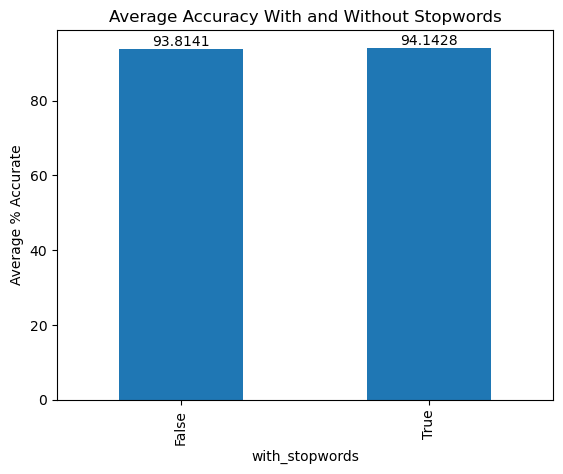

In [42]:
all_results = pd.concat([with_stopwords_table, wo_stopwords_table])

accuracy_graph = all_results.groupby('with_stopwords')['accuracy'].mean().plot.bar()
accuracy_graph.bar_label(accuracy_graph.containers[0])
plt.title('Average Accuracy With and Without Stopwords')
plt.ylabel('Average % Accurate')

plt.show()

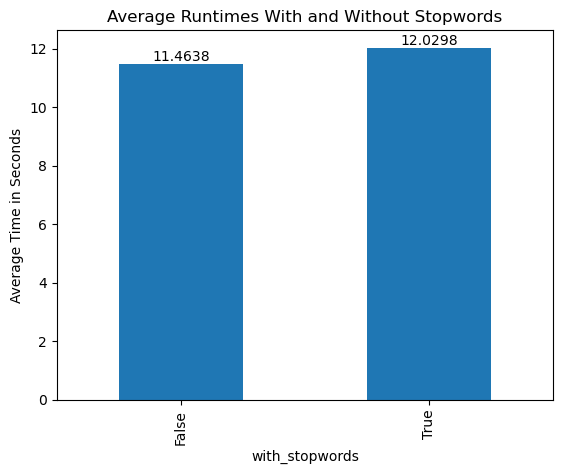

In [43]:
time_graph = all_results.groupby('with_stopwords')['time_elapsed'].mean().plot.bar()
time_graph.bar_label(time_graph.containers[0])
plt.title('Average Runtimes With and Without Stopwords')
plt.ylabel('Average Time in Seconds')
plt.show()

## Input Experiment

In [44]:
input_experiment_results = perform_input_experiment(df)
input_experiment_results

,inputs,avg_accuracy,std_dev_accuracy,avg_time,TP,TN,FP,FN
0,100,93.000000,4.472136,0.376821,26,67,5,2
1,200,92.500000,3.061862,0.600434,58,127,9,6
2,300,94.333333,2.527625,0.807140,88,195,11,6
3,400,91.000000,2.984334,1.026518,106,258,24,12
4,500,92.800000,3.563706,1.252597,150,314,27,9
5,600,93.833333,2.173067,1.449242,156,407,25,12
6,700,94.142857,2.643822,1.670062,190,469,21,20
7,800,93.750000,2.296397,1.899155,207,543,34,16
8,900,93.111111,1.337955,2.112985,223,615,48,14
9,1000,92.800000,2.196588,2.338129,255,673,48,24


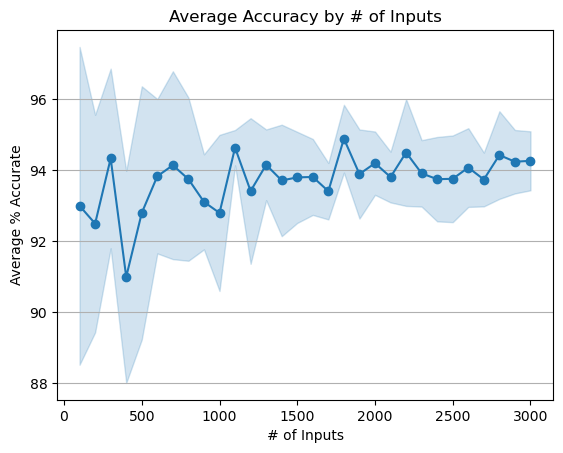

In [45]:
visualize_accuracy_by_input(input_experiment_results['inputs'], input_experiment_results['avg_accuracy'], input_experiment_results['std_dev_accuracy'])

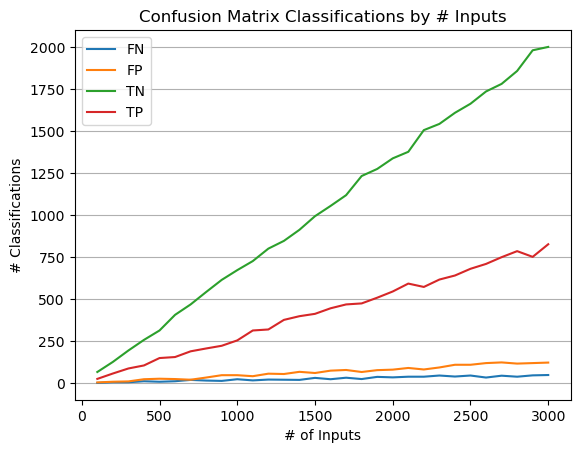

In [46]:
plt.plot(input_experiment_results['inputs'], input_experiment_results['FN'], label='FN')
plt.plot(input_experiment_results['inputs'], input_experiment_results['FP'], label='FP')
plt.plot(input_experiment_results['inputs'], input_experiment_results['TN'], label='TN')
plt.plot(input_experiment_results['inputs'], input_experiment_results['TP'], label='TP')
plt.legend()
plt.grid(axis='y')
plt.xlabel('# of Inputs')
plt.ylabel('# Classifications')
plt.title('Confusion Matrix Classifications by # Inputs')
plt.show()

## Balanced Input Experiment

In [47]:
balanced_input_experiment_results = perform_input_experiment(df, True)
balanced_input_experiment_results

,inputs,avg_accuracy,std_dev_accuracy,avg_time,TP,TN,FP,FN
0,100,88.000000,4.472136,0.381633,46,42,8,4
1,200,91.500000,5.184110,0.593348,88,95,5,12
2,300,92.333333,1.490712,0.813869,142,135,15,8
3,400,95.500000,1.425219,1.013516,193,189,11,7
4,500,93.200000,3.114482,1440.345042,240,226,24,10
5,600,92.666667,3.248931,4.589579,285,271,29,15
6,700,94.285714,2.314550,1446.548045,335,325,25,15
7,800,94.500000,1.354968,4.450837,380,376,24,20
8,900,95.000000,1.619709,1447.844846,431,424,26,19
9,1000,94.400000,1.981161,9.772144,478,466,34,22


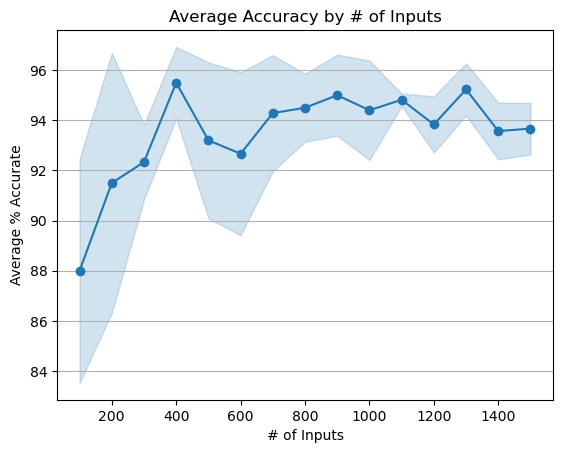

In [48]:
visualize_accuracy_by_input(balanced_input_experiment_results['inputs'], balanced_input_experiment_results['avg_accuracy'], balanced_input_experiment_results['std_dev_accuracy'])

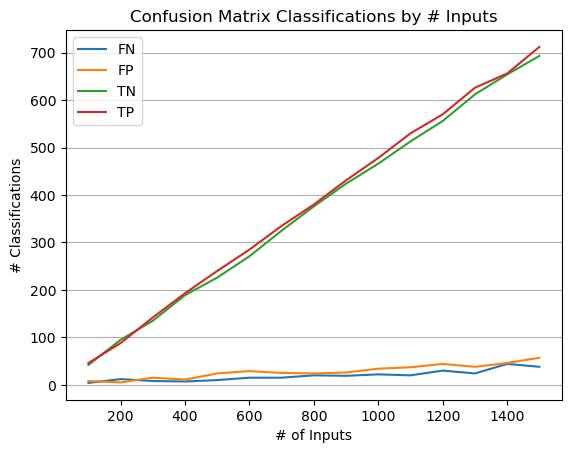

In [49]:
plt.plot(balanced_input_experiment_results['inputs'], balanced_input_experiment_results['FN'], label='FN')
plt.plot(balanced_input_experiment_results['inputs'], balanced_input_experiment_results['FP'], label='FP')
plt.plot(balanced_input_experiment_results['inputs'], balanced_input_experiment_results['TN'], label='TN')
plt.plot(balanced_input_experiment_results['inputs'], balanced_input_experiment_results['TP'], label='TP')
plt.legend()
plt.grid(axis='y')
plt.xlabel('# of Inputs')
plt.ylabel('# Classifications')
plt.title('Confusion Matrix Classifications by # Inputs')
plt.show()

## SVC Experiment

In [53]:
svm_input_experiment_results = perform_input_experiment(df, True, True)
svm_input_experiment_results

,inputs,avg_accuracy,std_dev_accuracy,TP,TN,FP,FN
0,100,67.000000,14.000000,7.4,6.0,4.4,2.2
1,200,66.000000,4.636809,18.2,8.2,10.2,3.4
2,300,65.333333,2.867442,27.2,12.0,20.4,0.4
3,400,80.750000,5.787918,37.0,27.6,7.2,8.2
4,500,79.600000,4.800000,37.0,42.6,6.4,14.0
5,600,84.166667,3.118048,58.0,43.0,15.0,4.0
6,700,83.428571,3.010187,63.4,53.4,21.0,2.2
7,800,93.375000,1.794088,78.6,70.8,5.6,5.0
8,900,89.444444,3.496029,86.8,74.2,16.4,2.6
9,1000,91.600000,2.939388,93.2,90.0,9.8,7.0


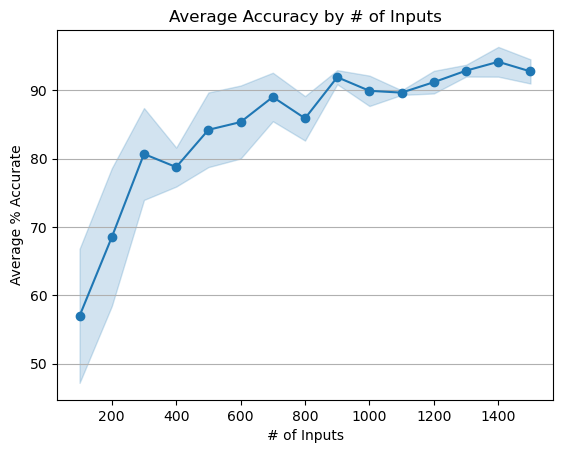

In [51]:
visualize_accuracy_by_input(svm_input_experiment_results['inputs'], svm_input_experiment_results['avg_accuracy'], svm_input_experiment_results['std_dev_accuracy'])

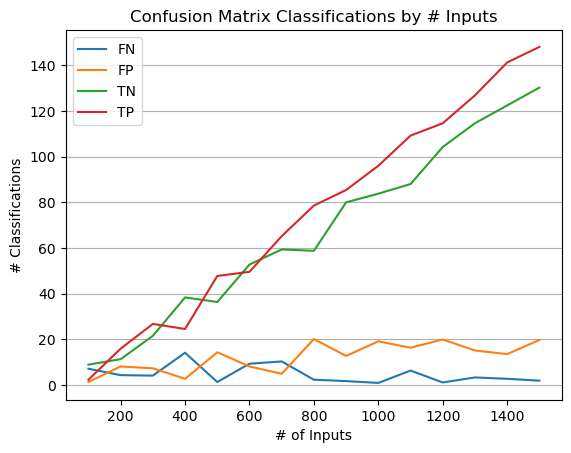

In [52]:
plt.plot(svm_input_experiment_results['inputs'], svm_input_experiment_results['FN'], label='FN')
plt.plot(svm_input_experiment_results['inputs'], svm_input_experiment_results['FP'], label='FP')
plt.plot(svm_input_experiment_results['inputs'], svm_input_experiment_results['TN'], label='TN')
plt.plot(svm_input_experiment_results['inputs'], svm_input_experiment_results['TP'], label='TP')
plt.legend()
plt.grid(axis='y')
plt.xlabel('# of Inputs')
plt.ylabel('# Classifications')
plt.title('Confusion Matrix Classifications by # Inputs')
plt.show()